# Midterm project

Congratulations! You've been hired as a data scientist at the hottest new social media startup.

Your company produces an app via which users can post short videos for anyone to view. They can also like, repost, and comment on the videos they view. The key data product is a recommendation engine that determines the order in which videos are shown to a user.

The recommendation engine has a parameter, *theta*, that affects the ordering of the videos. Recently the team of engineers that works on the recommendation engine ran it with different settings of *theta* and, for each setting, measured the amount of time users spent on the app. They have collected these measurements into a data set of 20 samples of (*theta*, *time_spent*) pairs.

Additionally, they have identified two auxiliary features (*aux1* and *aux2*) that they hypoithesize should correlate with *time_spent*. These two features are measures of time spent by users in the recent past. The engineers have not verified that the features explain *time_spent*.

(The engineers call these two features "auxiliary" because, while they might help explain *time_spent*, the engineers' ultimate interest lies in the dependence of *time_spent* on *theta*.)

Your first project at your new company is to tell the engineers which setting you think they should use for *theta*, based on the data.

In [14]:
# Importing required libraries
import pandas as pd 
import numpy as np
import ppscore
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## 1. Prepare the data
- Inspect the data. Identifiy and remove any suspicious or unusable samples.
- Put the samples in a data structure that you can work with.

In [15]:
theta = [0.03906292, 0.05119367, 0.06004468, 0.06790036, 0.19152079,
       0.28298816, 0.294665  , 0.3578136 , 0.48352862, 0.53058676,
       0.55175137, 0.57560289, 0.59751325, 0.6375209 , 0.65241862,
       0.65633352, 0.78698546, 0.8640421 , 0.87729053, 0.94568319]
aux1 = [ 0.53983961, -1.77528229,  1.31487654, -0.47344805, -1.0922299 ,
       -0.25002744, -0.9822943 ,  1.03126909,  0.49133378, -0.4466466 ,
       -0.80636008,  0.13126776, -1.21256024,  0.15999085, -0.75522304,
        0.34989599,  0.97754176, -0.13858525,  0.10385631,  0.30059104]
aux2 = [ 0.9682053 ,  0.86962384,  0.56778309,  0.46528234, -1.16537308,
       -2.03599479, -1.15541329,  3.34515739,  0.12672721, -0.6941789 ,
        0.55767443,  0.0991466 ,  0.63792617,  0.70311068, -0.91609315,
       -0.78601423,  1.1191818 , -0.98339611,  0.24452002, -0.58140974]
time_spent = [10.79768391, 10.87648065, 10.29274937, 10.78756647,  9.51844772,
        9.18078781,  9.90063639, 12.84823357, 10.92743478,  9.88927608,
       11.3373709 , 11.43996915, 11.88392171, -11.88135476, 11.73452467,
       11.18844425, 12.19144316, 11.35294826, 12.2385441 , 11.98428985]

df = pd.DataFrame({"theta": theta, "aux1": aux1, "aux2":aux2, "time_spent": time_spent})
print(df.shape)
df.sample(9)

(20, 4)


,theta,aux1,aux2,time_spent
4,0.191521,-1.092230,-1.165373,9.518448
15,0.656334,0.349896,-0.786014,11.188444
16,0.786985,0.977542,1.119182,12.191443
13,0.637521,0.159991,0.703111,-11.881355
12,0.597513,-1.212560,0.637926,11.883922
8,0.483529,0.491334,0.126727,10.927435
1,0.051194,-1.775282,0.869624,10.876481
9,0.530587,-0.446647,-0.694179,9.889276
0,0.039063,0.539840,0.968205,10.797684


In [16]:
def get_outlier_idx_using_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    upperouts = dataframe[dataframe[col_name] > upper_limit].index.to_list()
    lowerouts = dataframe[dataframe[col_name] < lower_limit].index.to_list()
    final_idx = []
    final_idx.extend(lowerouts)
    final_idx.extend(upperouts)
    if final_idx:
        print(f"Outliers in {col_name} are present at {final_idx}" )
    else:
        print("There are no outlies present in ", col_name)
    return final_idx

### Detecting and removing outliers from each feature

In [17]:
idx = get_outlier_idx_using_iqr(df, "theta") # Detecting outliers in Theta feature
idx = get_outlier_idx_using_iqr(df, "aux1") # Detecting outliers in Aux1 feature
idx = get_outlier_idx_using_iqr(df, 'aux2') # Detecting outliers in Aux2 feature
df.drop(idx, inplace=True) # Dropping the outlier

There are no outlies present in  theta
There are no outlies present in  aux1
Outliers in aux2 are present at [7]


In [18]:
# Removing data point with negative time spent
df.drop(df[df.time_spent<0].index, inplace=True) 
df.reset_index(drop=True, inplace=True)
print("Final dataset shape:", df.shape)
df

Final dataset shape: (18, 4)


,theta,aux1,aux2,time_spent
0,0.039063,0.539840,0.968205,10.797684
1,0.051194,-1.775282,0.869624,10.876481
2,0.060045,1.314877,0.567783,10.292749
3,0.067900,-0.473448,0.465282,10.787566
4,0.191521,-1.092230,-1.165373,9.518448
5,0.282988,-0.250027,-2.035995,9.180788
6,0.294665,-0.982294,-1.155413,9.900636
7,0.483529,0.491334,0.126727,10.927435
8,0.530587,-0.446647,-0.694179,9.889276
9,0.551751,-0.806360,0.557674,11.337371


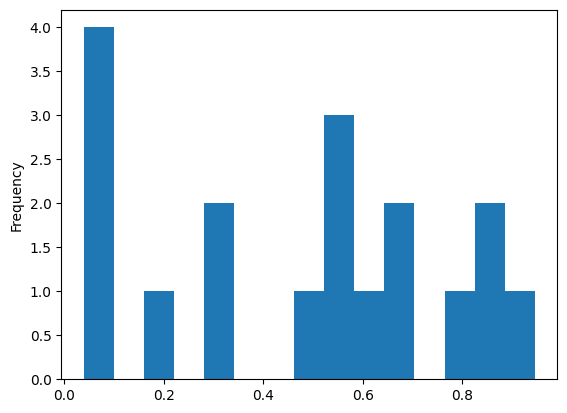

In [19]:
df['theta'].plot(bins=15, kind='hist');

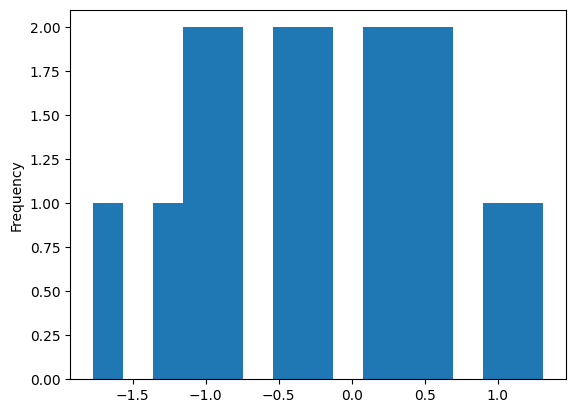

In [20]:
df['aux1'].plot(bins=15, kind='hist');

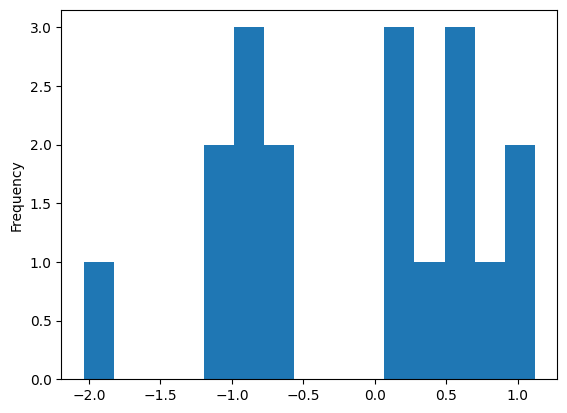

In [21]:
df.aux2.plot(bins=15, kind='hist');

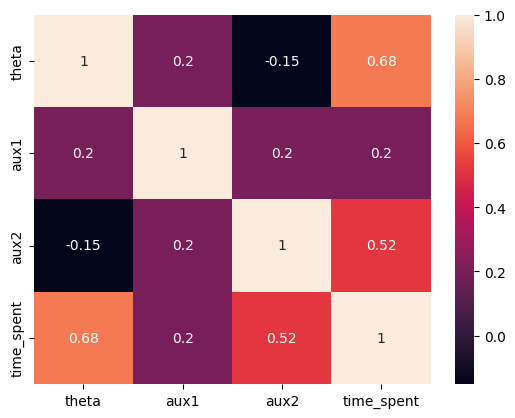

In [22]:
# Correlation plot
sns.heatmap(df.corr(), annot=True);

## 2. Build a model  

Write functions to run a regression, calculate the regression statistics listed below, and print a report.
- B (regressor coefficients plus one for an intercept, if appropriate)
- R2
- RSS
- RegSS
- TSS
- t statistic for each regressor coefficient

I found it useful to decompose the problem into three functions: `regress_calc()`, `regress_tstat()`, and `regress_report()`. You may write it however you see fit.  

You may include either, both, or neither of *aux1* and *aux2* in your final model. Experiment. What works best? Justify your decision.

In [23]:
from sklearn.linear_model import LinearRegression
from scipy.stats import t

def Regression_calc(features):
    print(features)
    X, y = df[features], df.iloc[:, -1]
    model = LinearRegression().fit(X, y)
    alpha, beta = model.intercept_, model.coef_[0]
    preds = model.predict(X)
    TSS = ((y - y.mean())**2).sum()
    RSS = ((y - preds)**2).sum()
    RegSS = TSS - RSS
    R2 = RegSS / TSS
    t_scores = beta / (np.std(X)/np.sqrt(len(X))) 
    t_statistics = list(t_scores)
    p_values = (t.sf(np.abs(t_scores), df=len(X)))*2
    return alpha, beta, preds, R2, RSS, RegSS, TSS, p_values, t_statistics
    
def t_stat(p_values):
    return np.array(p_values) < 0.05

def regress_report(features):
    alpha, beta, preds, R2, RSS, RegSS, TSS, p_values, t_statistics = Regression_calc(features)
    print("Significance values:", t_stat(p_values))
    print(f"Beta: {beta}, Alpha: {alpha}")
    print('Predictions:', preds)
    print("Total Sum of Squares:", TSS)
    print("Residual Sum of Squares:", RSS)
    print("Regression Sum of Squares:", RegSS)
    print("T statistics:", t_statistics)
    print("R2 Score:", R2)

#### For start I'm considering Theta as it is the highest correlated feature with time spent after that we will apply multiple combinations of the features and the best one will be the ones/one with the significant p values and the R2 score closer to 1.

In [24]:
feature_combinations = [['theta','aux1','aux2'],['aux1','aux2'],['theta','aux1'], 
                        ['theta','aux2'],['theta'],['aux1'],['aux2']]
for features in feature_combinations:
    print("\n")
    regress_report(features)



['theta', 'aux1', 'aux2']
Significance values: [ True  True  True]
Beta: 2.387782010713605, Alpha: 9.921886750105543
Predictions: [10.6011632  10.79422518 10.31007428 10.43818526  9.71766336  9.27768716
  9.95964321 11.11150076 10.77456313 11.68749542 11.34878616 11.88998193
 10.94945843 10.93530641 12.44341733 11.34927006 12.16787577 11.76622216]
Total Sum of Squares: 14.251632696903888
Residual Sum of Squares: 1.9653234005697902
Regression Sum of Squares: 12.286309296334098
T statistics: [34.10859477892874, 12.846403878429172, 11.49615327713406]
R2 Score: 0.8620983684910186


['aux1', 'aux2']
Significance values: [False False]
Beta: 0.11572630660613004, Alpha: 11.071331021870192
Predictions: [11.61777502 11.30057725 11.50731079 11.24911822 10.36240399 10.02467707
 10.38010496 11.19153755 10.67264766 11.25677496 11.13608191 11.24988182
 10.52601045 10.71892348 11.7438963  10.56372938 11.20557653 10.81549189]
Total Sum of Squares: 14.251632696903888
Residual Sum of Squares: 10.316400

Observations:
- Combination [theta, aux1, and aux2] has R2 score of 0.8620983 and P values are all significant.
- Combination [theta, aux2] has R2 score of 0.8551283 and P values are all significant.
- As the difference between the above two combinations is not even 1 percent I would choose [theta, and aux2 ] for my final model 
as it would reduce dimensions and make the model more interpretable.

## 3. Propose a setting for *theta*

Now that you have a model built, you should be able to plot estimated *time_spent* vs. *theta* over a reasonable range of *theta*.  By inspecting that plot -- and knowning that the company wants to maximize the time users spend on the app -- which value of *theta* would you propose the engineers use? Explain how the data and your model support your decision.

The engineer's have capacity to take another set of measurements. Which settings of *theta* do you suggest they measure? Why?


,Theta,Predicted time spent
0,0.039063,10.089089
1,0.051194,10.113828
2,0.060045,10.131878
3,0.067900,10.147898
4,0.191521,10.400000
5,0.282988,10.586532
6,0.294665,10.610344
7,0.483529,10.995498
8,0.530587,11.091465
9,0.551751,11.134627


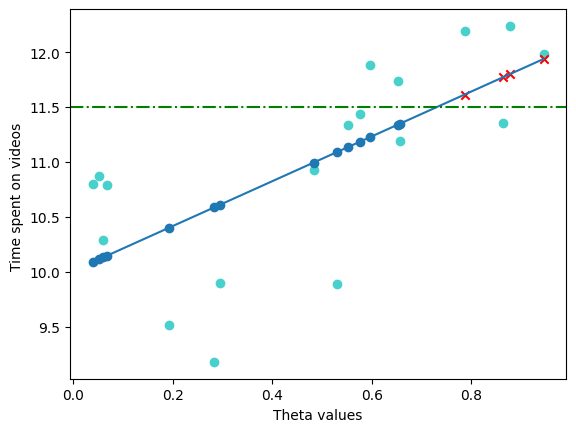

In [25]:
model = LinearRegression().fit(df.theta.to_numpy().reshape(-1, 1), df.time_spent)
alpha, beta = model.intercept_, model.coef_
time_spents = df.theta * model.coef_ + model.intercept_
plt.scatter(df.theta, df.time_spent, c="mediumturquoise")
plt.plot(df.theta, time_spents)

# thetas = np.linspace(0, 1, 10)
time_spents = df.theta * beta + alpha

plt.scatter(df.theta[:-4], df.theta[:-4]*beta + alpha)
plt.scatter(df.theta.iloc[np.argsort(np.sort(time_spents))][-4:], np.sort(time_spents)[-4:], color='red', marker="x")
plt.axhline(linestyle = "-.", y=11.5, color='green')
plt.xlabel("Theta values")
plt.ylabel("Time spent on videos ")

pd.DataFrame({"Theta": df.theta, "Predicted time spent": time_spents})

### Observations
- As we can see that as theta value increases the value of customer time spent increases.
- As shown in the above table and seen in the figure I would recommend to choose theta values above 0.85 to increase the time spent by the user on the videos.
- I propose 0.786985, 0.864042, 0.877291, and 0.945683 values for theta.

## 4. Experiment or observation?

Is this data set experimental or observational? Explain clearly. Consider how the effect of *theta* on *time_spent* differs from the effect of *aux1* or *aux2*.

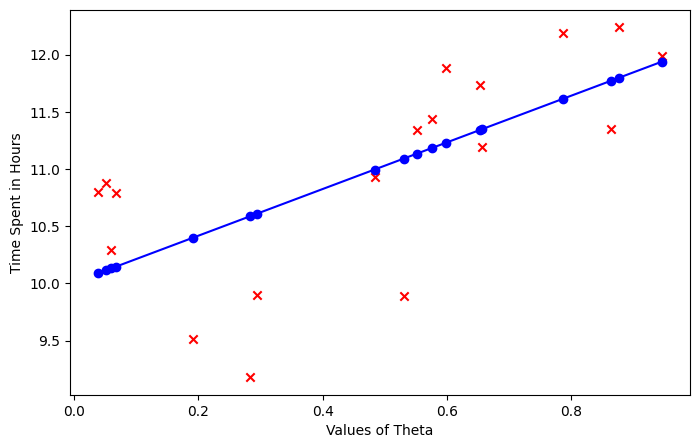

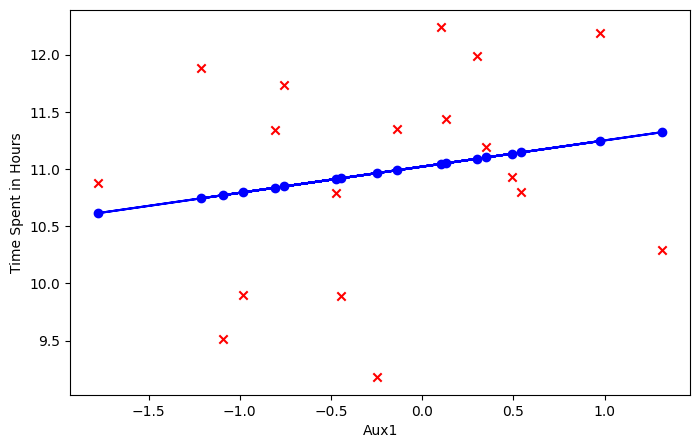

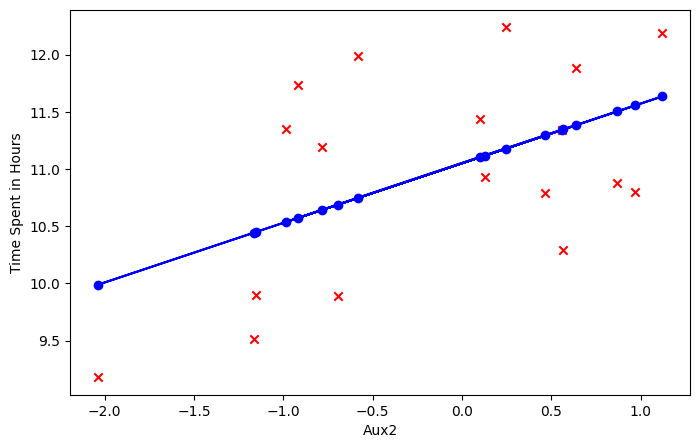

In [26]:
plt.figure(figsize=(8,5))
plt.xlabel('Values of Theta')
plt.ylabel('Time Spent in Hours')
X1, y = df[['theta']], df.time_spent
reg1 = LinearRegression().fit(X1, y) # Fit the best fit line
y_hat1 = reg1.predict(X1)
plt.scatter(X1, y, c='r',marker='x') 
plt.plot(X1, y_hat1, c='b', marker='o')

X2 = df[['aux1']]
reg2 = LinearRegression().fit(X2, y) # Fit the best fit line
y_hat2 = reg2.predict(X2)
plt.figure(figsize=(8,5))
plt.xlabel('Aux1')
plt.ylabel('Time Spent in Hours')
plt.scatter(X2, y, c='r',marker='x') 
plt.plot(X2, y_hat2, c='b', marker='o')

X3 = df[['aux2']]
reg3 = LinearRegression().fit(X3, y) # Fit the best fit line
y_hat3 = reg3.predict(X3)
plt.figure(figsize=(8,5))
plt.xlabel('Aux2')
plt.ylabel('Time Spent in Hours')
plt.scatter(X3, y, c='r',marker='x') 
plt.plot(X3, y_hat3, c='b', marker='o')

The problem statement is observational as the startup is trying to find out how the values of theta, aux1, and aux2 are affecting the customers time spent on the videos. To qualify it as the experimental dataset we must propose new data and use experimental methods and find if the results are replicable.

## Presentation 

You will give a 5 minute presentation in class. Your presentation should focus on step 3, above: Summarize your results, display any relevant visualization, and provide guidance to the engineers in the form of recommended setting for *theta*. Also please let the engineers know which value(s) of *theta* you think they should measure next.

# References

- https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_OpenIntro_Statistics_(Diez_et_al)./07%3A_Introduction_to_Linear_Regression/7.04%3A_Types_of_Outliers_in_Linear_Regression
- https://www.statsmodels.org/stable/api.html